In [2]:
import tkinter as tk
from tkinter import ttk
import os
from tkinter import filedialog
from typing import List
import xlstools
from xlstools import open_workbook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

SPATIAL_RESOLUTION = 0.1 #cm
BIN_WIDTH = 1 #cGy
DOSE_UNIT = 'cGy'
VOLUME_UNIT = '%'
MAX_DOSE_ABS_VOLUME = 0.03 #cm3
corrected_dict = {}

In [16]:
class Structure:
    def __init__(self, label, dose_axis, cumulated_percent_volume_axis):
        self.label = 'Paciente' if label == 'Paciente(Unsp.Tiss.)' else label
        self.volume = None
        self.dose_axis = dose_axis
        self.cumulated_percent_volume_axis = cumulated_percent_volume_axis
        self.differential_percent_volume_axis = -np.diff(self.cumulated_percent_volume_axis, 
                                              axis=0, 
                                              prepend=self.cumulated_percent_volume_axis[0])
        self.mean = self._mean_calculation()
        self.constraints = []

    def _mean_calculation(self):
        sum_dummy = (self.differential_percent_volume_axis*self.dose_axis).sum()
        sum_dummy /= self.differential_percent_volume_axis.sum()
        sum_dummy -= 1
        return sum_dummy

    def volume_update(self, volume: float) -> None:
        self.volume = volume

    def volume_function(self, dose):   # Entrada de dosis en cGy, devuelve en porcentaje de volumen
        return round(np.interp(dose, self.dose_axis, self.cumulated_percent_volume_axis), 1)
    
    def dose_function(self, volume):   # Entrada de volumen en porcentaje, devuelve dosis en cGy
        return round(np.interp(volume, self.cumulated_percent_volume_axis, self.dose_axis), 1)

class DVH:
    def __init__(self, file_path):
        # self.file_path = self._file_finder('Seleccione el archivo DVH.')
        self.file_path = file_path
        self.patient_id, self.plan_name, self.date_and_time, self.structures = self._DVH_data_parser()

    def _file_finder(self, window_title: str) -> str:
        tk.Tk().withdraw() # prevents an empty tkinter window from appearing
        my_directory = filedialog.askopenfilename(initialdir=os.getcwd(), 
                                           title=window_title, 
                                           filetypes=[("TXT Files", "*.txt")])
        return(my_directory)

    def _DVH_data_parser(self) -> List:
            try:
                with open(self.file_path, 'r') as file:
                    data = file.readlines()
                    header = data[0]

                    patient_id = header.split(' ')[2]
                    plan_name = header.split(' ')[6]
                    date_and_time = data[-1]

                    structures_list = {}

                    for row in data[3:-3]:
                        row = row.replace('\n','').split('                    ')
                        key = row[0]
                        values = [float(row[1]), float(row[2])]
                        
                        # Verificar si la key ya existe en el diccionario
                        if key in structures_list:
                            structures_list[key].append(values)
                        else:
                            structures_list[key] = [values]

                    structures = []
                    
                    for key in structures_list:
                        # convierto a numpy.array para poder transponer
                        dummy = np.array(structures_list[key]).T
                        if key in ['Camilla', 'Espuma']:     # Estructuras que no nos interesa evaluar
                            continue
                        structures.append(Structure(key,dummy[0],dummy[1]))
                           
                    return patient_id, plan_name, date_and_time, structures
                
            except FileNotFoundError:
                print(f"El archivo '{self.archivo}' no fue encontrado.")
            except Exception as e:
                print(f"Error al leer el archivo: {e}")

    def plot(self, DIFFERENTIAL_DVH: bool=False) -> None:
        print('Resumen de datos del DVH ingresado:')
        print(self.patient_id)
        print(self.plan_name)
        print(self.date_and_time)
        print('\n')

        plt.figure()
        for structure in self.structures:
            print(f'{structure.label}:\t{structure.mean:.1f} cGy')
            if DIFFERENTIAL_DVH:
                plt.plot(structure.dose_axis, 
                         structure.differential_percent_volume_axis, 
                         label=structure.label)
                plt.title('Differential dose-volume histogram')
                plt.ylim([0,1.5])
            else:
                plt.plot(structure.dose_axis, 
                         structure.cumulated_percent_volume_axis, 
                         label=structure.label)
                plt.title('Cumulated dose-volume histogram')
     
        plt.xlabel('Dosis[cGy]')
        plt.ylabel('Volume[%]')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid()
        plt.show()


In [20]:
class Constraint:
    def __init__(self, constraints_chart_line):
        self.structure_name, self.type, self.ideal_dose, self.ideal_volume, self.acceptable_dose, self.acceptable_volume = constraints_chart_line
        self.VERIFIED_IDEAL = (False, 0.0)
        self.VERIFIED_ACCEPTABLE = (False, 0.0)

    def verify(self, structure: Structure):
        constraint_types = ['V(D)>V_%', 'V(D)>V_cc', 'V(D)<V_%', 'V(D)<V_cc', 'D(V_%)<D', 'D(V_cc)<D', 'Dmax', 'Dmedia']
        
        if self.ideal_dose != 'None': 
            IDEAL_LV_AVAILABLE = True
        if self.acceptable_dose != 'None': 
            ACCEPTABLE_LV_AVAILABLE = True

        # INFERIOR and SUPERIOR CONTRAINT
        if self.type in (constraint_types[0], constraint_types[1], constraint_types[2], constraint_types[3]):
            is_superior = self.type in (constraint_types[2], constraint_types[3])
            abs_volume = self.type in (constraint_types[1], constraint_types[3])

            if IDEAL_LV_AVAILABLE:
                ref_dose = float(self.ideal_dose)
                ref_vol  = float(self.ideal_volume)
                result = structure.volume_function(ref_dose)
                result = result * structure.volume/100.0 if abs_volume else result
                if (is_superior and result <= ref_vol) or (not is_superior and result >= ref_vol):
                    self.VERIFIED_IDEAL = (True, round(result, 1))
                    return
            elif ACCEPTABLE_LV_AVAILABLE:
                ref_dose = float(self.acceptable_dose)
                ref_vol  = float(self.acceptable_volume)
                result = structure.volume_function(ref_dose)
                result = result * structure.volume/100.0 if abs_volume else result
                if (is_superior and result <= ref_vol) or (not is_superior and result >= ref_vol):
                    self.VERIFIED_ACCEPTABLE = (True, round(result, 1))
                    return

        elif self.type in (constraint_types[4], constraint_types[5]):
            abs_volume = self.type == constraint_types[5]

            if IDEAL_LV_AVAILABLE:
                ref_vol   = float(self.ideal_dose)  #cc
                ref_vol   = float( ref_vol*100.0/structure.volume if abs_volume else ref_vol ) #%
                ref_dose  = float(self.ideal_volume)
                result = structure.dose_function(ref_vol)
                if result <= ref_dose:
                    self.VERIFIED_IDEAL = (True, round(result, 1))
                    return
            elif ACCEPTABLE_LV_AVAILABLE:
                ref_vol   = float(self.acceptable_dose) #cc
                ref_vol   = float(ref_vol*100.0/structure.volume if abs_volume else ref_vol ) #%
                ref_dose  = float(self.acceptable_volume)
                result = structure.dose_function(ref_vol)
                if result <= ref_dose:
                    self.VERIFIED_IDEAL = (True, round(result, 1))
                    return
        
        elif self.type in (constraint_types[6], constraint_types[7]):
            dmax       = self.type == constraint_types[6]
            dmed       = self.type == constraint_types[7]

            if IDEAL_LV_AVAILABLE:
                if dmax:
                    ref_vol   = float( MAX_DOSE_ABS_VOLUME * 100.0/structure.volume)  #%
                ref_dose  = float(self.ideal_dose)
                result = structure.mean if dmed else structure.dose_function(ref_vol)
                if result <= ref_dose:
                    self.VERIFIED_IDEAL = (True, round(result, 1))
                    return
            elif ACCEPTABLE_LV_AVAILABLE:
                if dmax:
                    ref_vol   = float( MAX_DOSE_ABS_VOLUME * 100.0/structure.volume)  #%
                ref_dose  = float(self.acceptable_dose)
                result = structure.mean if dmed else structure.dose_function(ref_vol)
                if result <= ref_dose:
                    self.VERIFIED_ACCEPTABLE = (True, round(result, 1))
                    return

        self.VERIFIED_ACCEPTABLE = (False, round(result, 1))
            


class Prescription:
    def __init__(self, constraint_excel_filepath, presc_template_name):
        self.constraint_excel_filepath = constraint_excel_filepath
        self.presc_template_name = presc_template_name.upper()
        self.structures = {}

        constraints_chart = self._prescription_importer()

        target_chart = constraints_chart.pop(0)
        constraints_chart = [sublist[1:] for sublist in constraints_chart[0]]


        self.target_structures = {}
        for target_structure in target_chart:
            self.target_structures[target_structure[0]] = [int(x) for x in target_structure[1:3]]

        for constraint_chart_line in constraints_chart:
            new_structure_name = constraint_chart_line[0]
            if new_structure_name != 'None':
                structure_name = new_structure_name.upper()
                self.structures[structure_name] = []
                self.structures[structure_name].append(Constraint(constraint_chart_line))
            else:
                self.structures[structure_name].append(Constraint(constraint_chart_line))   

            
    def _prescription_importer(self):
        excel_data = xlstools.cell_data_importer(open_workbook(self.constraint_excel_filepath, self.presc_template_name),
                                                (4,'A'), 
                                                (45,'G'))

        chunks_charts = xlstools.none_based_data_parser(excel_data)

        assert len(chunks_charts)==2, "Error de importacion de chunks. Numero de chunks: "+f'{len(chunks_charts)}'
        if len(chunks_charts)==2:
            constraints_chart = [chunks_charts[0][1:], chunks_charts[1][2:]]

        return constraints_chart

    def print(self):
        print(f'Resumen de datos ingresados de la prescripcion: {self.presc_template_name}')
        print(f'PATH: {self.constraint_excel_filepath}')
        for structure_name, content in self.target_structures.items():
            print(f'{structure_name}:\t',content)
        
        dummy = []
        for structure_name, constraints in self.structures.items():
            for constraint in constraints:
                if constraint.VERIFIED_IDEAL[0]:
                    check = f'    PASS IDEAL: {constraint.VERIFIED_IDEAL[1]}'  
                elif constraint.VERIFIED_ACCEPTABLE[0]:
                    check = f'    PASS ACEPTABLE: {constraint.VERIFIED_ACCEPTABLE[1]}'
                else:
                    check = f'    FAIL: {constraint.VERIFIED_ACCEPTABLE[1]}'
                dummy.append([structure_name, constraint.type, constraint.ideal_dose, constraint.ideal_volume, constraint.acceptable_dose, constraint.acceptable_volume, check])
        print(pd.DataFrame(dummy).to_string(header=False, index=False))


In [5]:
def request_needed_volume(dvh: DVH, presc: Prescription):
    '''Chequea si las estructuras en dvh necesitan valor de volumen
    segun la presc elegida. Devuelve una lista con los nombres de las estructuras
    que necesitan volumen.'''
    need_volume = ['V(D)>V_cc', 'V(D)<V_cc', 'D(V_cc)<D', 'Dmax']
    structures_needing_volume = []
    for dvh_structure in dvh.structures:
        if dvh_structure.label not in presc.structures.keys():
            #print(dvh_structure.label)
            continue
        for constraint in presc.structures[dvh_structure.label]:
            if constraint.type in need_volume:
                if dvh.structures[dvh_structure.label].volume is not None:
                    continue
                else:
                    structures_needing_volume.append(dvh_structure.label)

    return structures_needing_volume

def structures_volume_entry(dvh: DVH, structures_needing_volume):
    # hay que revisar esto para que funcione bien adaptado a mi caso
    def submit_values():
        for i, entry in enumerate(entry_fields):
            try:
                value = int(entry.get())
                labels[i].config(text=f"{structures_needing_volume[i]}: {value}")
            except ValueError:
                labels[i].config(text=f"{structures_needing_volume[i]}: Invalid input")

    root = tk.Tk()
    root.title("Ingrese el volumen de las estructuras")

    labels = []
    entry_fields = []

    for text in structures_needing_volume:
        label = tk.Label(root, text=text)
        label.pack()
        entry = tk.Entry(root)
        entry.pack()
        labels.append(label)
        entry_fields.append(entry)

    submit_button = tk.Button(root, text="Ok", command=submit_values)
    submit_button.pack()

    root.mainloop()

def match_strings(list1, list2):
    def get_replacement_dict():
        misspelled_strings = [item2 for item2 in list2 if item2 not in list1]  # Get only misspelled strings

        for i, var in enumerate(selected_vars):    #en selected_vars estan los elementos de list2 elegidos
            value = var.get()
            if value != "":
                index = list2.index(misspelled_strings[i])  # Find the index of the misspelled string in list2
                corrected_dict[list2[index]] = value  # Add the correct value to the dictionary
            else:
                print(f'Se ignora estructura: {value}')  # If no correction was made, use the original string

        # Add the strings that were already present in list1
        for item in list2:
            if item not in corrected_dict:
                corrected_dict[item] = item

        root.destroy()

    root = tk.Tk()
    root.title("Mismatch de estructuras")

    label_title = tk.Label(root, text="Empareje las estructuras del plan con la correspondiente en la prescripción.")
    label_title.grid(row=0, columnspan=2)

    selected_vars = []
    row_count = 1  # Keep track of the current row

    for i, item2 in enumerate(list2):
        if item2 not in list1:  # Show only misspelled strings
            label = tk.Label(root, text=item2)
            label.grid(row=row_count, column=0)

            var = tk.StringVar()
            dropdown = ttk.Combobox(root, textvariable=var, values=list1)
            dropdown.grid(row=row_count, column=1)

            selected_vars.append(var)
            row_count += 1

    # Create a frame to hold the "OK" button at the bottom
    button_frame = tk.Frame(root)
    button_frame.grid(row=row_count, columnspan=2, sticky="ew")

    ok_button = tk.Button(button_frame, text="OK", command=get_replacement_dict)
    ok_button.pack(pady=10)  # Add padding to the button

    root.mainloop()


def dose_police_in_action(dvh: DVH, presc: Prescription):
    # CHEQUEANDO SI COINCIDEN LOS NOMBRES DE LAS ESTRUCTURAS EN PRESCRIPCION Y DVH
    dvh_structure_names = [structure.label.upper() for structure in dvh.structures]
    presc_structure_names = [structure_name.upper() for structure_name in presc.structures.keys()]
    match_strings(presc_structure_names, dvh_structure_names)

    for structure in dvh.structures:
        if structure.label not in presc_structure_names:
            continue
        structure.label = corrected_dict[structure.label]
        print(structure.label)


    # CHEQUEANDO SI SE NECESITA INGRESAR EL VALOR DE VOLUMEN DE ALGUNA ESTRUCTURA
    structures_needing_volume = request_needed_volume(dvh, presc)
    print(structures_needing_volume)

    if structures_needing_volume:
        structures_volume_entry(dvh, structures_needing_volume)


    # CHEQUEANDO CONSTRAINTS
    for dvh_structure in dvh.structures:
        dvh_structure_name = dvh_structure.label.replace(" ", "_").upper()
        if dvh_structure_name not in presc.structures.keys():
            print(dvh_structure_name+' skipped.')
            continue
        for constraint in presc.structures[dvh_structure_name]:
            print(f'{dvh_structure_name}: {constraint.type}')
            constraint.verify(dvh_structure)

  

Resumen de datos del DVH ingresado:
1~14759507
MAMAmDERmBOOST
2023-12-11-Mon  15:12:30


BOOST:	4837.2 cGy
CanalMedular:	24.0 cGy
Corazon:	80.1 cGy
Higado:	108.9 cGy
Mama_Izq:	50.8 cGy
Paciente:	234.7 cGy
PRV_Medula:	24.5 cGy
PTV_Lumpectomia:	4859.7 cGy
PTV_VMD:	4307.3 cGy
Pulmon_Der:	552.4 cGy
Pulmon_Izq:	29.2 cGy


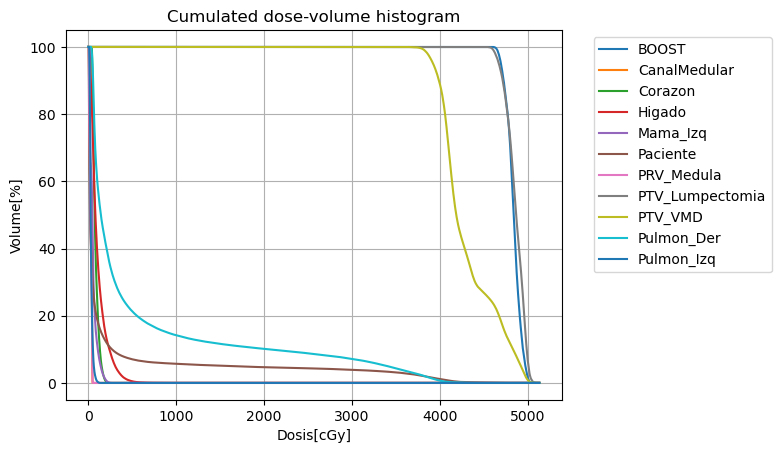

Resumen de datos ingresados de la prescripcion: VMD+BOOST INT
PATH: P:/8 - Físicos Médicos/Roy/INTECNUS-PreScript/protocols/Protocolo de constraints - Copy.xlsx
PTV_VMD:	 [4005, 267]
PTV_LUMP:	 [4800, 320]
   PTV_VMD V(D)>V_% 3885   95 3805   95     FAIL: 0.0
   PTV_VMD V(D)<V_% 4800   35 None None     FAIL: 0.0
   PTV_VMD V(D)<V_% 4320   50 None None     FAIL: 0.0
  PTV_LUMP V(D)>V_% 4656   95 None None     FAIL: 0.0
  PTV_LUMP V(D)<V_% 5280    5 None None     FAIL: 0.0
  PTV_LUMP     Dmax 5376 None None None     FAIL: 0.0
  MAMA_IZQ     Dmax  240 None  384 None     FAIL: 0.0
  MAMA_IZQ V(D)<V_%  144    5  240    5     FAIL: 0.0
PULMON_DER V(D)<V_% 1200   15 1200   20     FAIL: 0.0
PULMON_DER V(D)<V_%  800   30  800   35     FAIL: 0.0
PULMON_DER V(D)<V_%  400   40  400   55     FAIL: 0.0
PULMON_IZQ V(D)<V_%  400   10 None None     FAIL: 0.0
   CORAZON V(D)<V_% 1600    5 None None     FAIL: 0.0
   CORAZON V(D)<V_%  800   30 None None     FAIL: 0.0
   CORAZON     Dmax  320 None  400 Non

TypeError: unsupported operand type(s) for /: 'float' and 'NoneType'

In [21]:
file_path = 'P:/8 - Físicos Médicos/Roy/INTECNUS-Dose_Police/14759507_MAMAmDERmBOOST_DVH_1.txt'
dvh = DVH(file_path)

# PLOTEO Y PRINTEO DE DATOS INGRESADOS

dvh.plot()


#SETEO MANUAL DEL VOLUMEN DE LA MEDULAR
# OARs = ['CanalMedular', 'Mama_Izq', 'Paciente', 'PTV_VMD']
# for structure in dvh.structures:
#     if structure.label in OARs and structure.volume is None:
#         structure.volume = 30 #cc

constraint_excel_file_path = 'P:/8 - Físicos Médicos/Roy/INTECNUS-PreScript/protocols/Protocolo de constraints - Copy.xlsx'
presc_template_name = 'VMD+BOOST INT'

presc = Prescription(constraint_excel_file_path, presc_template_name)

presc.print()

dose_police_in_action(dvh, presc)   

print('\n')

# presc.print()